In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Function to find thresholds

In [ ]:
def find_threshold(
    da: xr.DataArray, 
    recurrence_period: int, 
    window: int, 
    agg_method: str, 
    period_dict: dict, 
    var_type: str
    ): 
    '''
    Finds extreme events and dates wrt a recurrence period threshold.

    input:
        da: DataArray
        recurrence_period: int x in expression "once every x years"
        window: int specifying the aggregation period
        agg_method: str specifying if aggregation by 'mean' or 'consecutive' days
        period_dict: with init_day and end_day to give dayofyear
    output:
        dates_extremes, extremes: dates when extremes are reached, and extreme value 
    '''

    interval = pd.Timedelta(f'{max(4, window//2+1)}d') # each search will remove data around extreme using interval
    n_events = 40 // recurrence_period # number of events to find
    dates_extremes = []
    extremes = []

    if agg_method == 'mean':
        da = da.resample(time=f'{window}d').mean('time')
    else: # For consecutive days above/below threshold... not used
        if var_type == 'max':
            da = da.resample(time=f'{window}d').min('time')
        else:
            da = da.resample(time=f'{window}d').max('time')
    da = da.sel(time=np.logical_and(da.time.dt.dayofyear>period_dict['init_day'],
                                    da.time.dt.dayofyear<period_dict['end_day']))
    
    for i in range(n_events+1): # We also want the most extreme event that falls outside criterion
        extremes.append(da.max('time').values)
        dates_extremes.append(da.isel(time=da.argmax().values).time.values)
        da = da.sel(time=np.logical_or(da.time < dates_extremes[i]-interval,
                                       da.time > dates_extremes[i]+interval))
    
    return dates_extremes, extremes

Define the variable and specify locations

In [2]:
var = 'tp' # Var name in ERA file. Either t2m_max, t2m_min or tp
file_var_dict = {'t2m_max': 'daily/2m_temperature_historical', # For file name
                 't2m_min': 'daily/2m_temperature',
                 'tp': 'total_precipitation/total_precipitation_1979_2019_v2'
                 }
lat_lon = [ # lat-lon locations for RZ (important client... not too representative)
    [47.1, -119.5],    # 0
    [47.7, -121.1],    # 1
    [45.2, -121.1],    # 2
    [-37, 140.7],      # 3
    [-37.4, 143.6],    # 4
    [-41.8, 147.2],    # 5
    [-39.8, 176.7],    # 6
    [47.1, -119.8],    # 7
    [45, -122.9],      # 8
    [-37.4, 144.2],    # 9
    [-37.7, 144.5],    # 10
]

Read zarr data

In [3]:
ds_era = xr.open_zarr(f'gcs://era_5_bucket/{file_var_dict[var]}.zarr', consolidated=True)
ds_era = ds_era.assign_coords(
    latitude=ds_era.latitude.fillna(0),
    longitude=ds_era.longitude.fillna(0)
)
ds_era

,Array,Chunk
Bytes,1.36 TiB,38.15 MiB
Shape,"(359393, 721, 1440)","(100000, 10, 10)"
Count,42049 Tasks,42048 Chunks
Type,float32,numpy.ndarray


Some basic preprocessing

In [ ]:
era = ds_era[var]
era_list = []
for latlon in lat_lon:
    da = era.sel(latitude=latlon[0], longitude=latlon[1], method='nearest')
    era_list.append(da)
era = xr.concat(era_list, dim='number')
if var == 'tp':
    era = era.resample(time='24H').sum('time') * 1000
era = era.load()


The main part of the code is below

32.728515625
26.999021530151367
52.7917594909668


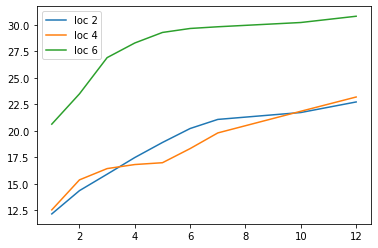

In [32]:
# Set dates below for dayofyear calculations
period_start = pd.to_datetime(f'01-01-2001')
period_end = pd.to_datetime(f'12-31-2001')
period_dict = {'init_day': period_start.dayofyear, 'end_day': period_end.dayofyear}

locs = [2,4,6] # locations (see lat_lon) 
x=[12,10,7,6,5,4,3,2,1] # recurrence period in years (once every x years)

for loc in locs:
    y=[]
    dts, xtrms = find_threshold(era.sel(number=loc), 1, 3, 'mean', period_dict, 'max')
    for xi in x:
        n = 40//xi
        y.append(.5*xtrms[n]+.5*xtrms[n-1])
    print(xtrms[0])
    plt.plot(x, y, label = f"loc {loc}")
    plt.legend()
plt.savefig(f'/home/jupyter/risks/RZ/imgs/{var}.png')#show()
#plt.clf()
